# 06-02: Molloy-Reed Configuration Model

*November 23 2022*  

In this notebook, we  implement the configuration model after Molloy and Reed, which can be used to generate random networks with arbitrary degree distributions.

In [1]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

In [3]:
def MolloyReed(degrees):
    # assume that we are given a graphical degree sequence
    if not pp.generators.is_graphic_Erdos_Gallai(degrees):
        return None
    
    # create empty network with n nodes
    n = len(degrees)
    g = pp.Network(directed = False)
    
    # generate link stubs based on degree sequence
    stubs = []
    for i in range(n):
        for k in range(degrees[i]):
            stubs.append(str(i))
    
    # connect randomly chosen pairs of link stubs
    # note: if relax is True, we allow self-loops and multi-edges, 
    # but remove them when we return the network. 
    # This implies that the returned network may not have 
    # exactly sum(degrees)/2 links.
    #print(stubs)
    while(len(stubs)>0):
        v, w = np.random.choice(stubs, 2, replace=False)
        if v!=w and ((v,w) not in g.edges):
            #print(v,w)
            stubs.remove(v)
            stubs.remove(w)        
            g.add_edge(str(v),str(w))
    
    return g

Note that there is no guarantee that we actually find a microstate with a given degree sequence, even if the sequence is graphic. We can run into situations where the only stubs left belong to pairs of nodes that are either already connected (or refer to the same node), i.e. they can not be removed if we do not allow self-loops and/or multi-edges. In the `pathpy` implementation, we fix this issue by additionally destroying a random existing edge whenever we sample a pair of nodes that would either lead to a self-loop or a multi-edge. This resolves situations in which the simple implementation above runs into an infinite loop. Nevertheless, you will find that even with this simple method the network generation will succeed quickly for a number of degree sequences, which highlights that the space of possible network realizations that are consistent with a given degree sequence is vast!

In the following, we use this function to generate a k-regular random network with $100$ nodes and $k = 2$, i.e. a network in which all nodes have a degree of exactly two.

In [4]:
n = MolloyReed([2]*100)
n.plot()

Following the approach explained in lecture L06, we can also generate networks with a fixed degree distribution rather than a fixed degree sequence. For this we first draw a degree sequence from a given distribution, check whether the sequence is graphic and then apply the configuration algorithm above. Below, we apply this to a sequence of 300 degrees drawn from a *Zipf* distribution with parameter $\gamma=2.7$, and a *Poisson* distribution with $\lambda=3$. We then generate two random networks with the drawn degree sequences, plot the networks as well as their degree distributions. To draw the degree sequences we can use the implementations of distributions in `np.random.zipf` and `np.random.poisson`.

In [6]:
degrees_zipf = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees_zipf):
    degrees_zipf = [int(x) for x in np.random.zipf(2.7, 300)]

In [7]:
degrees_poisson = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees_poisson):
    degrees_poisson = [int(x) for x in np.random.poisson(lam=3, size=300)]

/Users/ingo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


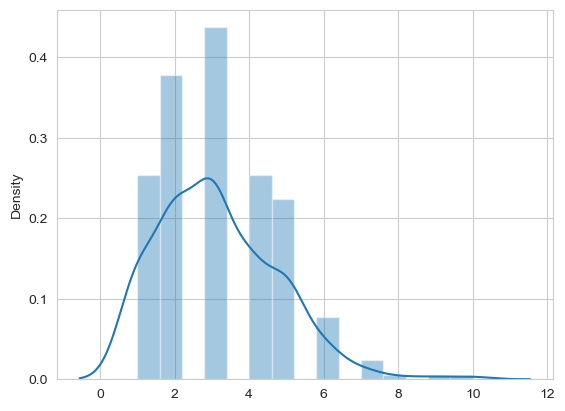

In [8]:
g_poisson = MolloyReed(degrees_poisson)
sns.distplot(pp.statistics.degree_sequence(g_poisson));
g_poisson.plot()

/Users/ingo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


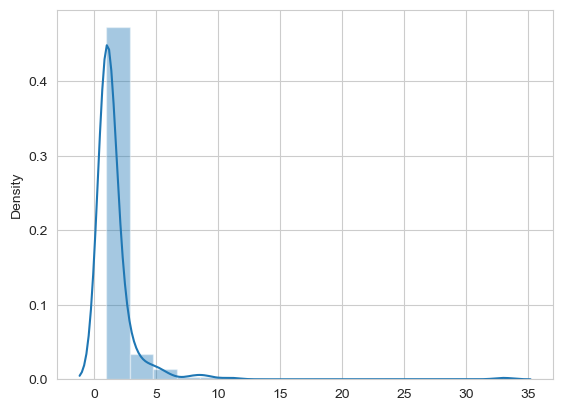

In [9]:
g_zipf = MolloyReed(degrees_zipf)
sns.distplot(pp.statistics.degree_sequence(g_zipf));
g_zipf.plot()

Note that the heterogeneity of a degree distribution can influence how easy it is to find a network with a given degree sequence drawn from that distribution. If we increase the heterogeneity of the Zipf distribution by reducing the exponent parameter, we will find that our simple implementation is likely to be stuck in an infinite loop:

In [13]:
degrees_zipf = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees_zipf):
    degrees_zipf = [int(x) for x in np.random.zipf(2.3, 500)]

If we use `pathpy`'s implementation instead (which additionally destroys already created edges whenever we find a pair of stubs that cannot be connected), the network creation succeeds quickly:

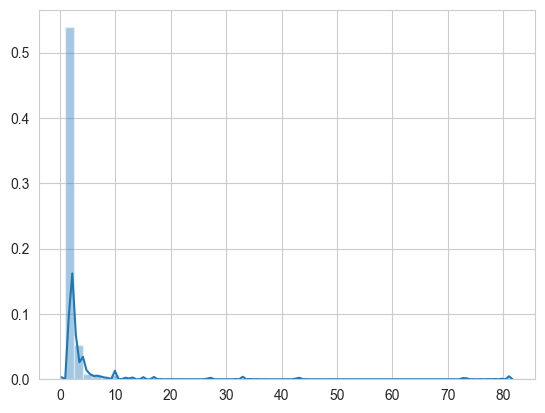

In [14]:
g_zipf = pp.generators.Molloy_Reed(degrees_zipf)
sns.distplot(pp.statistics.degree_sequence(g_zipf));
g_zipf.plot()

# Molloy-Reed model as null model for empirical networks

An important application of the Molloy-Reed model in statistical network analysis is as a null model that helps us to establish a baseline for what we can expect at random, if we account for the heterogeneous degrees in a real network. To show the advantage over simple rrandom graph models that only preserve the size of the network, we make an experiment with real data. We compare the diameter and average shortest path length of the largest connected component in empirical networks with those of random microstates generated using the $G(n,p)$ and the Molloy-Reed model. 

To simplify the generation of random microstates that preserve the macrostate of an empirical network, the functions in the module `pathpy.generators` come in a `randomize` version, which automatically preserve the corresponding macrostate of a given network. In the case of the $G(n,p)$ model this automatically adjust the parameters $n$ and $p$ such that the expected number of links matches the observed number of links in the given network. For the molloy-Reed model, the degree sequence of the empirical network is used in the generation of a random microstate. All other network properties like, e.g. node uids are preserved. We demonstrate this in the following example:

In [15]:
n_lotr = pp.io.sql.read_network('../data/networks.db', sql='SELECT DISTINCT source, target from lotr', directed=False)
n_lotr

[12-01 00:07:49: WARNING] 67 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


In [16]:
n = pp.generators.ER_np_randomize(n_lotr)
print(n)

Uid:			0x20179718048
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	139
Number of edges:	644


In [17]:
n = pp.generators.Molloy_Reed_randomize(n_lotr)
print(n)

Uid:			0x20178c9ba20
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	139
Number of edges:	634


In [18]:
n_gentoo = pp.io.sql.read_network('../data/networks.db', sql='SELECT source, target from gentoo', directed=False).largest_connected_component()
n_highschool = pp.io.sql.read_network('../data/networks.db', sql='SELECT source, target from highschool', directed=False).largest_connected_component()

[12-01 00:07:50: WARNING] 154 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


In [19]:
print("Empirical network has", n_gentoo.number_of_nodes(), "nodes and", n_gentoo.number_of_edges(), "edges")
print("Empirical network has diameter =", pp.algorithms.shortest_paths.diameter(n_gentoo))
print("Empirical network has avg. shortest path length =", pp.algorithms.shortest_paths.avg_path_length(n_gentoo))

Empirical network has 403 nodes and 513 edges
Empirical network has diameter = 8.0
Empirical network has avg. shortest path length = 3.1096379146451367


In [20]:
r_gentoo = pp.generators.random_graphs.ER_np_randomize(n_gentoo).largest_connected_component()
print("G(n,p) microstate has", r_gentoo.number_of_nodes(), "nodes and", r_gentoo.number_of_edges(), "edges")
print("G(n,p) microstate has diameter =", pp.algorithms.shortest_paths.diameter(r_gentoo))
print("G(n,p) microstate has avg. shortest path length =", pp.algorithms.shortest_paths.avg_path_length(r_gentoo))

G(n,p) microstate has 375 nodes and 527 edges
G(n,p) microstate has diameter = 16.0
G(n,p) microstate has avg. shortest path length = 6.1409910873440285


In [21]:
r_gentoo = pp.generators.random_graphs.Molloy_Reed_randomize(n_gentoo).largest_connected_component()
print("Molloy-Reed microstate has", r_gentoo.number_of_nodes(), "nodes and", r_gentoo.number_of_edges(), "edges")
print("Molloy-Reed microstate has diameter =", pp.algorithms.shortest_paths.diameter(r_gentoo))
print("Molloy-Reed microstate has avg. shortest path length =", pp.algorithms.shortest_paths.avg_path_length(r_gentoo))

Molloy-Reed microstate has 362 nodes and 492 edges
Molloy-Reed microstate has diameter = 6.0
Molloy-Reed microstate has avg. shortest path length = 2.670482545415589


In [22]:
print("Empirical network has", n_highschool.number_of_nodes(), "nodes and", n_highschool.number_of_edges(), "edges")
print("Empirical network has diameter =", pp.algorithms.shortest_paths.diameter(n_highschool))
print("Empirical network has avg. shortest path length =", pp.algorithms.shortest_paths.avg_path_length(n_highschool))

Empirical network has 120 nodes and 348 edges
Empirical network has diameter = 12.0
Empirical network has avg. shortest path length = 5.362745098039215


In [23]:
r_highschool = pp.generators.random_graphs.ER_np_randomize(n_highschool).largest_connected_component()
print("G(n,p) microstate has", r_highschool.number_of_nodes(), "nodes and", r_highschool.number_of_edges(), "edges")
print("G(n,p) microstate has diameter =", pp.algorithms.shortest_paths.diameter(r_highschool))
print("G(n,p) microstate has avg. shortest path length =", pp.algorithms.shortest_paths.avg_path_length(r_highschool))

G(n,p) microstate has 120 nodes and 358 edges
G(n,p) microstate has diameter = 5.0
G(n,p) microstate has avg. shortest path length = 2.842156862745098


In [24]:
r_highschool = pp.generators.random_graphs.Molloy_Reed_randomize(r_highschool).largest_connected_component()
print("Molloy-Reed microstate has", r_highschool.number_of_nodes(), "nodes and", r_highschool.number_of_edges(), "edges")
print("Molloy-Reed microstate has diameter =", pp.algorithms.shortest_paths.diameter(r_highschool))
print("Molloy-Reed microstate has avg. shortest path length =", pp.algorithms.shortest_paths.avg_path_length(r_highschool))

Molloy-Reed microstate has 120 nodes and 358 edges
Molloy-Reed microstate has diameter = 5.0
Molloy-Reed microstate has avg. shortest path length = 2.8591036414565827
